# NB 02: Functional Characterization of Costly + Dispensable Genes

Compare functional profiles across the four selection signature quadrants
using SEED and KEGG annotations. Test whether costly+dispensable genes
are enriched in mobile genetic elements, defense systems, or other functions.

**Run locally** — uses `data/gene_quadrants.tsv` from NB01.

**Outputs**: 3 figures, enrichment tables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pathlib import Path

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_DIR.mkdir(exist_ok=True)

## 1. Load Data

In [2]:
# Gene quadrants from NB01
genes = pd.read_csv(DATA_DIR / 'gene_quadrants.tsv', sep='\t')
print(f"Gene quadrants: {len(genes):,} genes")
print(genes['quadrant'].value_counts())

# SEED annotations
seed = pd.read_csv(
    '../../conservation_vs_fitness/data/seed_annotations.tsv',
    sep='\t'
)
print(f"\nSEED annotations: {len(seed):,}")

# SEED hierarchy
seed_hier = pd.read_csv(
    '../../conservation_vs_fitness/data/seed_hierarchy.tsv',
    sep='\t'
)
print(f"SEED hierarchy: {len(seed_hier):,} entries")

# KEGG annotations
kegg = pd.read_csv(
    '../../conservation_vs_fitness/data/kegg_annotations.tsv',
    sep='\t'
)
print(f"KEGG annotations: {len(kegg):,}")

Gene quadrants: 142,190 genes
quadrant
neutral_conserved      86761
costly_conserved       28017
neutral_dispensable    21886
costly_dispensable      5526
Name: count, dtype: int64

SEED annotations: 125,167
SEED hierarchy: 5,774 entries
KEGG annotations: 73,077


In [3]:
# Merge SEED annotations with hierarchy to get top-level categories
seed_with_hier = seed.merge(seed_hier, on='seed_desc', how='left')

# Deduplicate: one SEED top-level per gene (take first match)
# This avoids row inflation from genes with multiple SEED annotations
seed_dedup = seed_with_hier.sort_values('toplevel', na_position='last') \
    .drop_duplicates(subset=['orgId', 'locusId'], keep='first')

# Merge with gene quadrants (1:1, no inflation)
genes_seed = genes.merge(
    seed_dedup[['orgId', 'locusId', 'seed_desc', 'toplevel', 'category', 'subsystem']],
    on=['orgId', 'locusId'],
    how='left'
)
genes_seed['has_seed'] = genes_seed['seed_desc'].notna()
genes_seed['has_toplevel'] = genes_seed['toplevel'].notna()

# Verify no row inflation
assert len(genes_seed) == len(genes), f"Row inflation! {len(genes_seed)} != {len(genes)}"

# KEGG: also deduplicate
kegg_dedup = kegg.drop_duplicates(subset=['orgId', 'locusId'], keep='first')
genes_kegg = genes.merge(
    kegg_dedup[['orgId', 'locusId', 'kgroup', 'kegg_desc']],
    on=['orgId', 'locusId'],
    how='left'
)
genes_kegg['has_kegg'] = genes_kegg['kegg_desc'].notna()
assert len(genes_kegg) == len(genes), f"Row inflation! {len(genes_kegg)} != {len(genes)}"

print(f"Genes with SEED annotation: {genes_seed['has_seed'].sum():,} ({genes_seed['has_seed'].mean()*100:.1f}%)")
print(f"Genes with SEED top-level: {genes_seed['has_toplevel'].sum():,} ({genes_seed['has_toplevel'].mean()*100:.1f}%)")
print(f"Genes with KEGG annotation: {genes_kegg['has_kegg'].sum():,} ({genes_kegg['has_kegg'].mean()*100:.1f}%)")
print(f"Row count preserved: {len(genes_seed):,} (expected {len(genes):,})")

Genes with SEED annotation: 97,560 (68.6%)
Genes with SEED top-level: 44,204 (31.1%)
Genes with KEGG annotation: 49,168 (34.6%)
Row count preserved: 142,190 (expected 142,190)


## 2. Annotation Rate by Quadrant

In [4]:
# Annotation rate by quadrant
annot_rate = genes_seed.groupby('quadrant').agg(
    n_genes=('locusId', 'count'),
    pct_seed=('has_seed', 'mean'),
    pct_toplevel=('has_toplevel', 'mean'),
).reset_index()

kegg_rate = genes_kegg.groupby('quadrant')['has_kegg'].mean().reset_index()
kegg_rate.columns = ['quadrant', 'pct_kegg']
annot_rate = annot_rate.merge(kegg_rate, on='quadrant')

for col in ['pct_seed', 'pct_toplevel', 'pct_kegg']:
    annot_rate[col] = (annot_rate[col] * 100).round(1)

print("Annotation rate by quadrant:")
annot_rate

Annotation rate by quadrant:


,quadrant,n_genes,pct_seed,pct_toplevel,pct_kegg
0,costly_conserved,28017,74.9,35.8,42.7
1,costly_dispensable,5526,50.8,20.8,20.0
2,neutral_conserved,86761,72.1,33.2,37.1
3,neutral_dispensable,21886,51.3,19.1,18.0


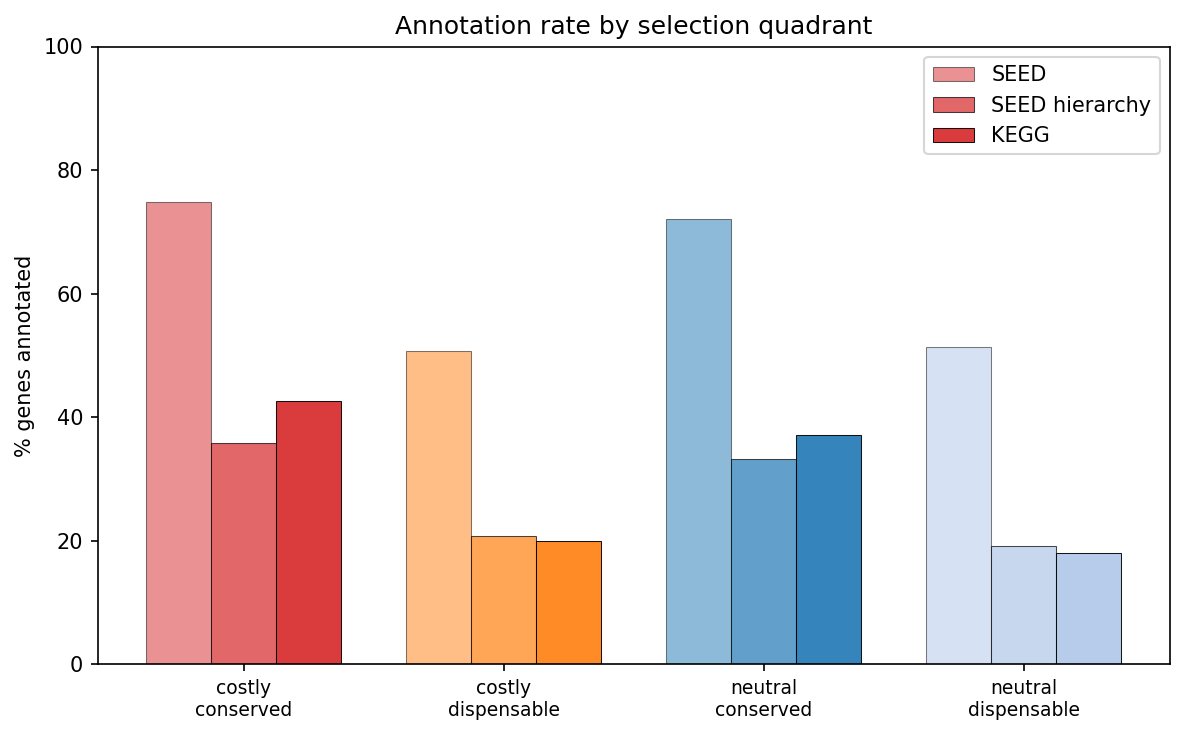

In [5]:
# Figure 1: Annotation rate by quadrant
fig, ax = plt.subplots(figsize=(8, 5))

quad_order = ['costly_conserved', 'costly_dispensable', 'neutral_conserved', 'neutral_dispensable']
quad_colors = {'costly_conserved': '#d62728', 'costly_dispensable': '#ff7f0e',
               'neutral_conserved': '#1f77b4', 'neutral_dispensable': '#aec7e8'}

x = np.arange(len(quad_order))
width = 0.25

for i, (col, label) in enumerate([('pct_seed', 'SEED'), ('pct_toplevel', 'SEED hierarchy'), ('pct_kegg', 'KEGG')]):
    vals = [annot_rate[annot_rate['quadrant'] == q][col].iloc[0] for q in quad_order]
    ax.bar(x + i * width, vals, width, label=label,
           color=[quad_colors[q] for q in quad_order], alpha=0.5 + i * 0.2,
           edgecolor='black', linewidth=0.5)

ax.set_xticks(x + width)
ax.set_xticklabels([q.replace('_', '\n') for q in quad_order], fontsize=9)
ax.set_ylabel('% genes annotated')
ax.set_title('Annotation rate by selection quadrant')
ax.legend()
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_annotation_rate.png')
plt.show()

## 3. SEED Top-Level Enrichment

For each SEED top-level category, test enrichment in costly+dispensable
vs costly+conserved using Fisher exact tests with BH-FDR correction.

In [6]:
# SEED top-level enrichment: costly_dispensable vs costly_conserved
cd = genes_seed[genes_seed['quadrant'] == 'costly_dispensable']
cc = genes_seed[genes_seed['quadrant'] == 'costly_conserved']

toplevels = genes_seed['toplevel'].dropna().unique()

enrichment_results = []
for tl in sorted(toplevels):
    cd_in = (cd['toplevel'] == tl).sum()
    cd_out = len(cd) - cd_in
    cc_in = (cc['toplevel'] == tl).sum()
    cc_out = len(cc) - cc_in
    
    table = [[cd_in, cd_out], [cc_in, cc_out]]
    odds, pval = stats.fisher_exact(table)
    
    cd_pct = cd_in / len(cd) * 100 if len(cd) > 0 else 0
    cc_pct = cc_in / len(cc) * 100 if len(cc) > 0 else 0
    
    enrichment_results.append({
        'toplevel': tl,
        'cd_count': cd_in,
        'cd_pct': cd_pct,
        'cc_count': cc_in,
        'cc_pct': cc_pct,
        'odds_ratio': odds,
        'p_value': pval
    })

enrich_df = pd.DataFrame(enrichment_results)

# BH-FDR correction
_, enrich_df['fdr'], _, _ = multipletests(enrich_df['p_value'], method='fdr_bh')
enrich_df['significant'] = enrich_df['fdr'] < 0.05
enrich_df = enrich_df.sort_values('odds_ratio', ascending=False)

print("SEED top-level enrichment (costly+dispensable vs costly+conserved):")
print(enrich_df.to_string(index=False))

SEED top-level enrichment (costly+dispensable vs costly+conserved):
                                          toplevel  cd_count   cd_pct  cc_count   cc_pct  odds_ratio      p_value          fdr  significant
                                         Virulence        21 0.380022         4 0.014277   26.715395 2.214429e-13 1.284369e-12         True
Phages, Prophages, Transposable elements, Plasmids        39 0.705755        17 0.060677   11.706815 1.302107e-18 1.258703e-17         True
                             Cell Wall and Capsule       132 2.388708       365 1.302780    1.853944 1.091105e-08 2.876549e-08         True
                  Metabolism of Aromatic Compounds        34 0.615273       147 0.524681    1.173730 4.209290e-01 4.882776e-01        False
                    Virulence, Disease and Defense        51 0.922910       259 0.924439    0.998331 1.000000e+00 1.000000e+00        False
                                 Sulfur Metabolism        15 0.271444        84 0.299818    

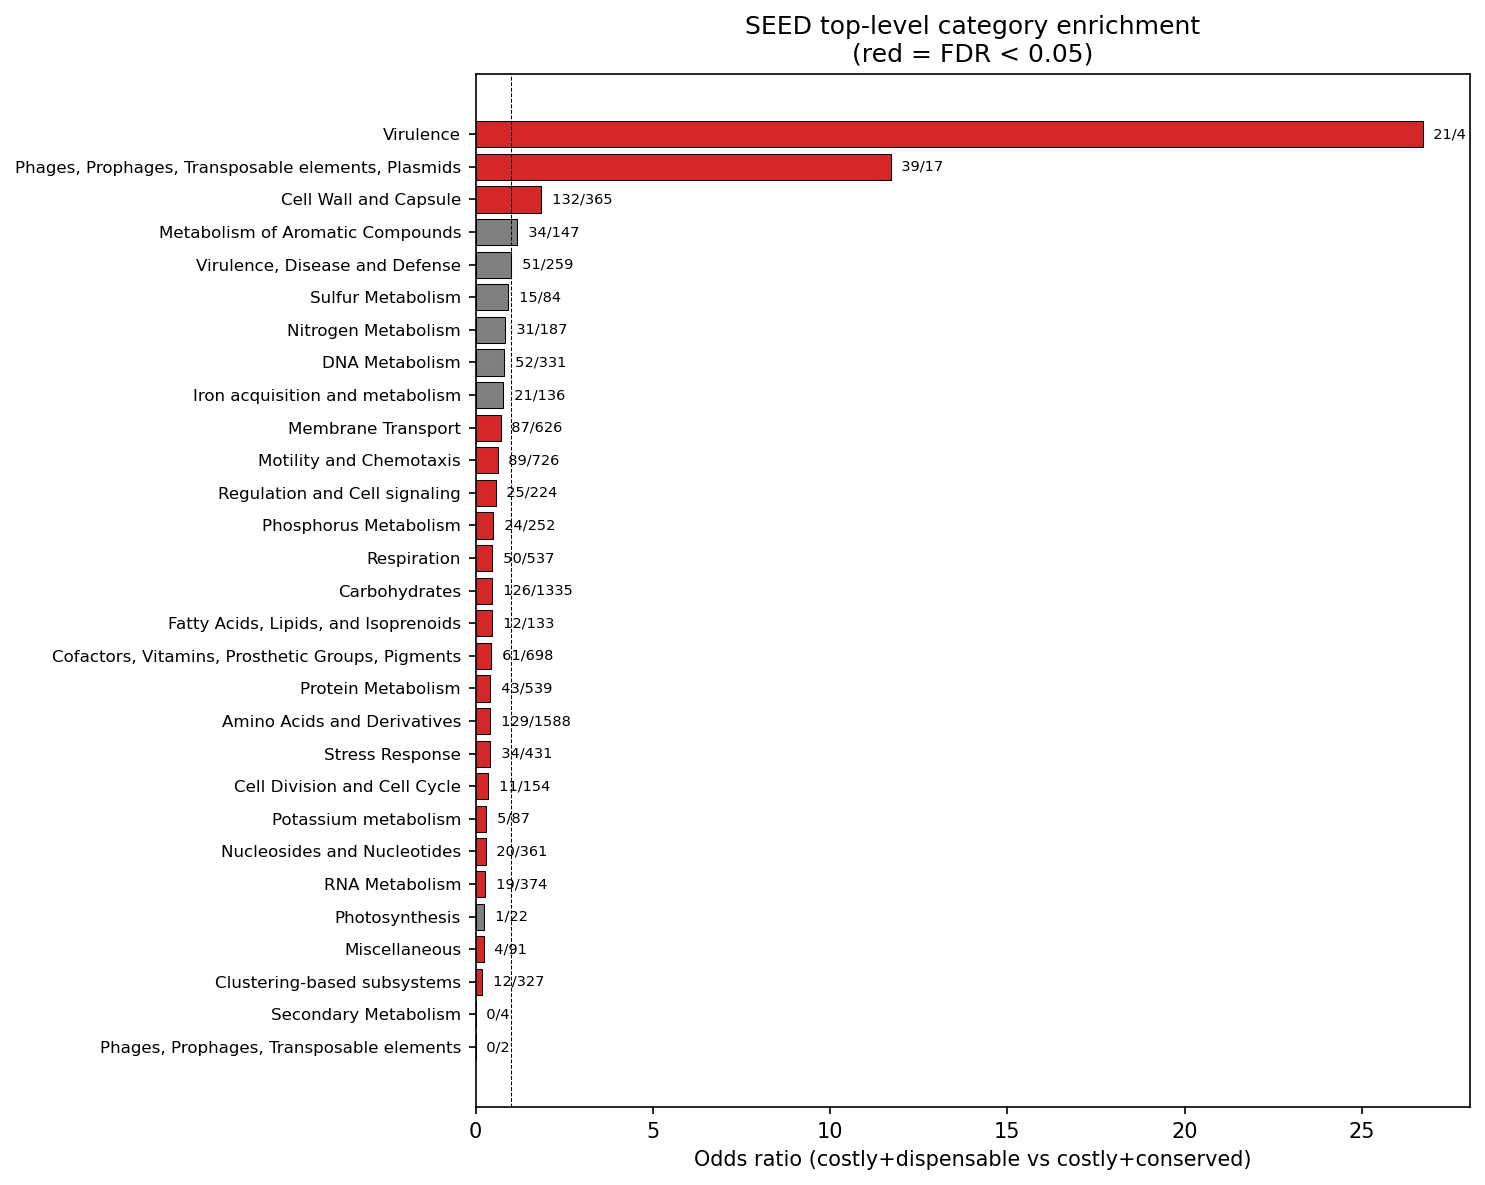

In [7]:
# Figure 2: SEED enrichment forest plot
fig, ax = plt.subplots(figsize=(10, 8))

plot_df = enrich_df.sort_values('odds_ratio').copy()
y_pos = range(len(plot_df))

colors = ['#d62728' if sig else '#7f7f7f' for sig in plot_df['significant']]
ax.barh(y_pos, plot_df['odds_ratio'], color=colors, edgecolor='black', linewidth=0.5)
ax.axvline(1.0, color='black', linestyle='--', linewidth=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df['toplevel'], fontsize=8)
ax.set_xlabel('Odds ratio (costly+dispensable vs costly+conserved)')
ax.set_title('SEED top-level category enrichment\n(red = FDR < 0.05)')

# Add count labels
for i, (_, row) in enumerate(plot_df.iterrows()):
    label = f"  {row['cd_count']}/{row['cc_count']}"
    ax.text(max(row['odds_ratio'], 0) + 0.05, i, label, va='center', fontsize=7)

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_seed_enrichment.png')
plt.show()

## 4. Mobile Element Keyword Analysis

In [8]:
# Search gene descriptions for mobile element keywords
mobile_keywords = [
    'transposase', 'integrase', 'phage', 'prophage',
    'IS element', 'IS\\d', 'recombinase', 'insertion sequence',
    'toxin-antitoxin', 'restriction', 'CRISPR',
    'conjugal', 'plasmid', 'type IV secretion',
]
pattern = '|'.join(mobile_keywords)

genes['has_mobile_keyword'] = genes['desc'].str.contains(
    pattern, case=False, na=False
)

mobile_by_quad = genes.groupby('quadrant')['has_mobile_keyword'].agg(['sum', 'mean']).reset_index()
mobile_by_quad.columns = ['quadrant', 'n_mobile', 'pct_mobile']
mobile_by_quad['pct_mobile'] = (mobile_by_quad['pct_mobile'] * 100).round(2)

print("Mobile element keyword prevalence by quadrant:")
print(mobile_by_quad.to_string(index=False))

# Fisher exact: costly_dispensable vs costly_conserved for mobile keywords
cd_mob = genes[(genes['quadrant'] == 'costly_dispensable') & genes['has_mobile_keyword']]
cd_nomob = genes[(genes['quadrant'] == 'costly_dispensable') & ~genes['has_mobile_keyword']]
cc_mob = genes[(genes['quadrant'] == 'costly_conserved') & genes['has_mobile_keyword']]
cc_nomob = genes[(genes['quadrant'] == 'costly_conserved') & ~genes['has_mobile_keyword']]

table = [[len(cd_mob), len(cd_nomob)], [len(cc_mob), len(cc_nomob)]]
odds, pval = stats.fisher_exact(table)
print(f"\nMobile element enrichment (costly+dispensable vs costly+conserved):")
print(f"  OR={odds:.2f}, p={pval:.4g}")

Mobile element keyword prevalence by quadrant:
           quadrant  n_mobile  pct_mobile
   costly_conserved       142        0.51
 costly_dispensable       202        3.66
  neutral_conserved       511        0.59
neutral_dispensable       916        4.19

Mobile element enrichment (costly+dispensable vs costly+conserved):
  OR=7.45, p=4.592e-71


## 5. Organism Distribution

In [9]:
# Which organisms contribute the most costly+dispensable genes?
org_quad = genes.groupby(['orgId', 'quadrant']).size().unstack(fill_value=0)
org_quad['total'] = org_quad.sum(axis=1)
org_quad['pct_costly_dispensable'] = (
    org_quad.get('costly_dispensable', 0) / org_quad['total'] * 100
).round(1)
org_quad = org_quad.sort_values('pct_costly_dispensable', ascending=False)

print("Top 15 organisms by % costly+dispensable genes:")
print(org_quad[['costly_dispensable', 'costly_conserved', 'total', 'pct_costly_dispensable']].head(15).to_string())

Top 15 organisms by % costly+dispensable genes:
quadrant          costly_dispensable  costly_conserved  total  pct_costly_dispensable
orgId                                                                                
psRCH2                           715               925   3321                    21.5
Miya                              13                21     67                    19.4
Btheta                           557              1212   3988                    14.0
ANA3                             294              1262   3609                     8.1
Marino                           242               774   3526                     6.9
Methanococcus_S2                  84               411   1219                     6.9
azobra                           201               547   2969                     6.8
pseudo1_N1B4                     270               841   4016                     6.7
acidovorax_3H11                  243               857   3767                     6.5
Koxy  

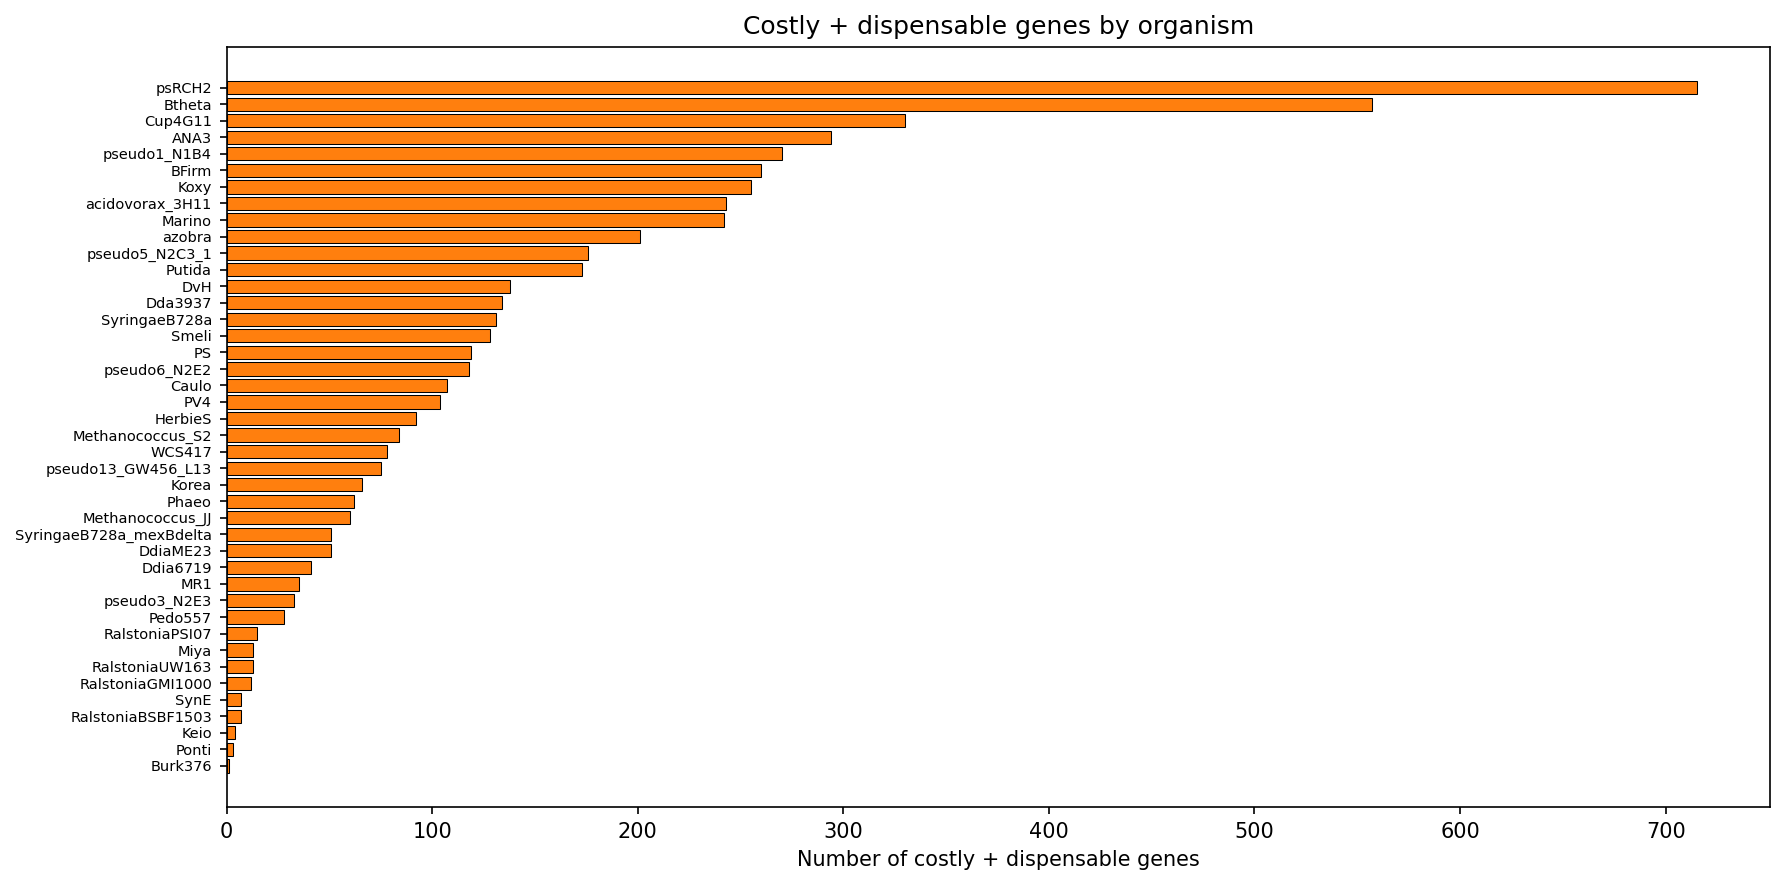

In [10]:
# Figure 3: Per-organism costly+dispensable gene counts
fig, ax = plt.subplots(figsize=(12, 6))

org_cd = genes[genes['quadrant'] == 'costly_dispensable']['orgId'].value_counts().sort_values(ascending=True)
ax.barh(range(len(org_cd)), org_cd.values, color='#ff7f0e', edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(org_cd)))
ax.set_yticklabels(org_cd.index, fontsize=7)
ax.set_xlabel('Number of costly + dispensable genes')
ax.set_title('Costly + dispensable genes by organism')

plt.tight_layout()
plt.savefig(FIG_DIR / 'fig_organism_distribution.png')
plt.show()

## 6. Summary

In [11]:
n_sig = enrich_df['significant'].sum()
enriched = enrich_df[(enrich_df['significant']) & (enrich_df['odds_ratio'] > 1)]['toplevel'].tolist()
depleted = enrich_df[(enrich_df['significant']) & (enrich_df['odds_ratio'] < 1)]['toplevel'].tolist()

print("=" * 60)
print("NB02 SUMMARY: Functional Characterization")
print("=" * 60)
print()
print("Annotation rates (costly+dispensable vs costly+conserved):")
cd_row = annot_rate[annot_rate['quadrant'] == 'costly_dispensable'].iloc[0]
cc_row = annot_rate[annot_rate['quadrant'] == 'costly_conserved'].iloc[0]
print(f"  SEED: {cd_row['pct_seed']}% vs {cc_row['pct_seed']}%")
print(f"  KEGG: {cd_row['pct_kegg']}% vs {cc_row['pct_kegg']}%")
print()
print(f"SEED enrichment tests: {n_sig} significant (FDR < 0.05)")
if enriched:
    print(f"  Enriched in costly+dispensable: {', '.join(enriched)}")
if depleted:
    print(f"  Depleted in costly+dispensable: {', '.join(depleted)}")
print()
print(f"Mobile element keywords: OR={odds:.2f}, p={pval:.4g}")
print("=" * 60)

NB02 SUMMARY: Functional Characterization

Annotation rates (costly+dispensable vs costly+conserved):
  SEED: 50.8% vs 74.9%
  KEGG: 20.0% vs 42.7%

SEED enrichment tests: 20 significant (FDR < 0.05)
  Enriched in costly+dispensable: Virulence, Phages, Prophages, Transposable elements, Plasmids, Cell Wall and Capsule
  Depleted in costly+dispensable: Membrane Transport, Motility and Chemotaxis, Regulation and Cell signaling, Phosphorus Metabolism, Respiration, Carbohydrates, Fatty Acids, Lipids, and Isoprenoids, Cofactors, Vitamins, Prosthetic Groups, Pigments, Protein Metabolism, Amino Acids and Derivatives, Stress Response, Cell Division and Cell Cycle, Potassium metabolism, Nucleosides and Nucleotides, RNA Metabolism, Miscellaneous, Clustering-based subsystems

Mobile element keywords: OR=7.45, p=4.592e-71
